In [ ]:
# Done making this piece of code.
# Very straightforward, just a grid with an outer edge.

# However, note that now the edge will not be able to contain all the data
# points if the grid spacing is too large. This doesn't really matter, since
# all we want from this curve is choosing where we want to set the limit
# of the skimage algorithm. 

In [1]:
import numpy as np
import healpy as hp
import _maps as maps

import sys, os, time
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('default') 

In [4]:


# load energy bins
energy_list, energy_centers = maps.generate_energy_bins_()

# load local directory
username="ramirez"
maps_dir = "/het/p4/"+username+"/gcewavelets/skysearch/data/maps/"

# load map type (with ids corresponding to energy bin, random iteration, bkgd/ps ids)
model = 'SA0' # only available option: SA0
trial_id = str(0)
model_dir = maps_dir + (model + '_' + trial_id + '/')
energy_bin = 'all'
map_type = 'bkgd'
npix = 10

# load events from map 
if energy_bin == 'all' or energy_bin == str(-1):
    if map_type == 'bkgd':
        map_dir = model_dir + 'bkgd/'
    elif map_type == 'all':
        inj_id = sys.argv[6]
        map_dir = model_dir + ('bkgd_wps_' + inj_id + '/') 

else:
    ie = int(float(energy_bin))
    if map_type == 'bkgd':
        bkgd_dir = model_dir + 'bkgd/'
        map_dir = bkgd_dir + 'energy_bin_' + str(ie) + '/'
    elif map_type == 'all':
        inj_id = sys.argv[6]
        bkgd_wps_dir = model_dir + ('bkgd_wps_' + inj_id + '/')
        map_dir = bkgd_wps_dir + 'energy_bin_' + str(ie) + '/' 

In [5]:
# load events
events = np.load(map_dir + 'map.npy', allow_pickle = True)
l_events = events[:,0]
b_events = events[:,1]

# after loading the data, we need our angular coordinates to be given by
# longitude ([0,2\pi]) and latitude (-\pi, \pi)
phi_events = l_events.copy()
phi_events[phi_events>np.pi] = phi_events[phi_events>np.pi]-2*np.pi

lon_events = phi_events + np.pi
lat_events = b_events

# load healpix pixel edges, divide data into groups, calculate center of pixels for projection
NSIDE = 4
NPIX = hp.nside2npix(NSIDE)

# group points into patches (before projection)
unprojected_patches_file = map_dir + 'unprojected_patches.npz'
# if os.path.isfile(unprojected_patches_file) == True:
#     u_data = np.load(unprojected_patches_file, allow_pickle = True)
#     arr_edge_points, grouped_points_lon, grouped_points_lat, arr_c = [u_data[k] for k in u_data]
# else:    
arr_edge_points = maps.healpix_edge_generator_(NSIDE = 4, step = 100)
grouped_points_lon, grouped_points_lat = maps.divide_data_into_groups_(lon_events, lat_events, arr_edge_points)
arr_c = maps.father_pixel_center_generator_(arr_edge_points)
unprojected_data = [arr_edge_points, grouped_points_lon, grouped_points_lat, arr_c]
    # np.savez(unprojected_patches_file, *unprojected_data)

# load directories to save projected maps and plots
data_dir = map_dir + 'projected_maps/'
os.system("mkdir -p "+data_dir)

plot_dir = map_dir + 'projection_plots'
os.system("mkdir -p "+plot_dir)

# create projected map dictionary
projected_map = {}

# load and save coords of center of projected map wrt original spherical coords
lon_c = arr_c[npix,0] ; lat_c = arr_c[npix,1]
projected_map['center_coords'] = arr_c[npix,:]

# project each group of points into their respective tangent plane
lon_pix = grouped_points_lon[npix]
lat_pix = grouped_points_lat[npix]

lon_edge = arr_edge_points[npix, :, 0]
lat_edge = arr_edge_points[npix, :, 1]

r_pix = maps.tangent_plane_proj_(lat_pix, lon_pix, lat_c, lon_c)
r_edge = maps.tangent_plane_proj_(lat_edge, lon_edge, lat_c, lon_c)

projected_map['search_region_points'] = r_pix
projected_map['search_region_edge'] = r_edge

# generate first outer band of points outside each group 
ang_scale = 2 * np.pi / 180
lon_out, lat_out = maps.find_neighboring_points_(ang_scale, lon_events, lat_events, lon_edge, lat_edge)
r_out = maps.tangent_plane_proj_(lat_out, lon_out, lat_c, lon_c)
projected_map['outer_region_points'] = maps.remove_points_from_array_(r_out,r_pix)

Text(0, 0.5, '$y$ (rad)')

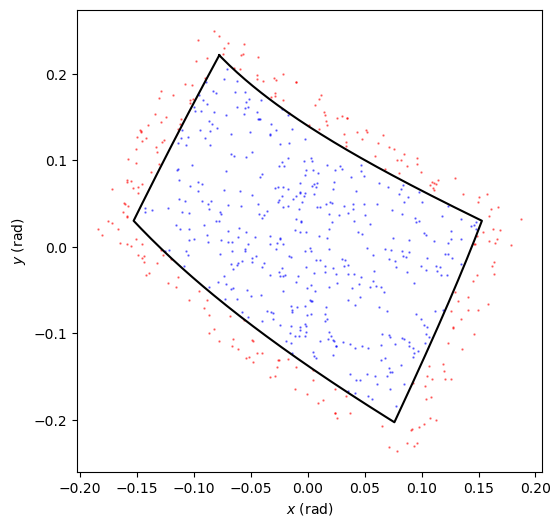

In [6]:
fig = plt.figure(1,figsize=(6,6))
ax = fig.add_subplot(111)

r_outer = projected_map['outer_region_points']
x_outer = r_outer[:,0] ; y_outer = r_outer[:,1]

r_pix = projected_map['search_region_points']
r_edge = projected_map['search_region_edge']

x_pix = r_pix[:,0] ; y_pix = r_pix[:,1]
x_edge = r_edge[:,0] ; y_edge = r_edge[:,1]

ax.scatter(x_outer,y_outer, c = 'r', alpha = 0.5, s = 0.5)
ax.scatter(x_pix,y_pix, c = 'b', alpha = 0.5, s = 0.5)
ax.plot(x_edge,y_edge, c = 'k')
ax.set_xlabel('$x$ (rad)')
ax.set_ylabel('$y$ (rad)')

In [35]:
grid_scale_deg = 0.25
grid_scale = grid_scale_deg * np.pi / 180
dev = 2.5 * np.pi / 180

x_min = np.min(x_edge) - dev ; x_max = np.max(x_edge) + dev ; y_min = np.min(y_edge) - dev ; y_max = np.max(y_edge) + dev

# generate grid lying inside 'outer_region_edge'
mesh_bxby, arr_b, arr_bx_plot, arr_by_plot = maps.build_mesh_(x_min, x_max, y_min, y_max, grid_scale, grid_scale, True)

Text(0, 0.5, '$y$ (rad)')

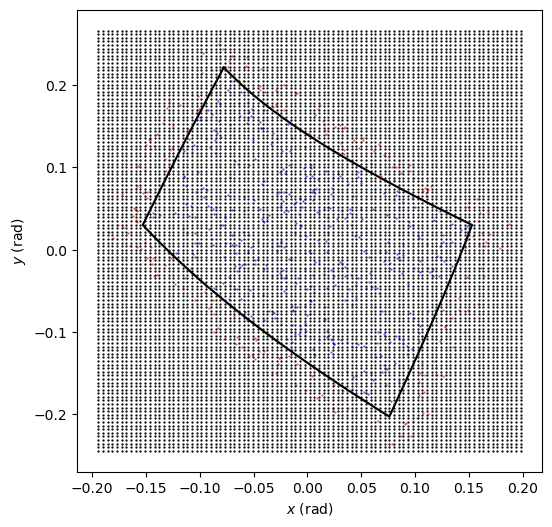

In [36]:
fig = plt.figure(1,figsize=(6,6))
ax = fig.add_subplot(111)

r_outer = projected_map['outer_region_points']
x_outer = r_outer[:,0] ; y_outer = r_outer[:,1]

r_pix = projected_map['search_region_points']
r_edge = projected_map['search_region_edge']

x_pix = r_pix[:,0] ; y_pix = r_pix[:,1]
x_edge = r_edge[:,0] ; y_edge = r_edge[:,1]

ax.scatter(x_outer,y_outer, c = 'r', alpha = 0.5, s = 0.5)
ax.scatter(x_pix,y_pix, c = 'b', alpha = 0.5, s = 0.5)
ax.plot(x_edge,y_edge, c = 'k')
ax.scatter(arr_b[:,0], arr_b[:,1], s = 0.4, c = 'k')
ax.set_xlabel('$x$ (rad)')
ax.set_ylabel('$y$ (rad)')

In [37]:
# generate boundary of band used for grid generation
# arr_bx = 0.5 * (arr_bx_plot[1:] + arr_bx_plot[:-1]) ; arr_by = 0.5 * (arr_by_plot[1:] + arr_by_plot[:-1])
# generate first outer band of points outside each group 
ang_scale = 2 * np.pi / 180
x_out_grid, y_out_grid = maps.find_neighboring_points_(ang_scale, arr_b[:,0], arr_b[:,1], x_edge, y_edge)
print(x_out_grid)
r_out_grid = np.stack((x_out_grid,y_out_grid), axis = -1)
# r_out_grid = maps.remove_points_from_array_(r_out_grid_redundant,r_pix)

outer_edge = maps.generate_edge_of_point_set_(r_out_grid[:,0], r_out_grid[:,1])
x_out_edge = outer_edge[:,0] ; y_out_edge = outer_edge[:,1]
r_out_edge = np.stack((x_out_edge,y_out_edge), axis = -1)
projected_map['outer_region_edge'] = r_out_edge

[-0.18566536 -0.18566536 -0.18566536 ...  0.1852171   0.1852171
  0.1852171 ]


Text(0, 0.5, '$y$ (rad)')

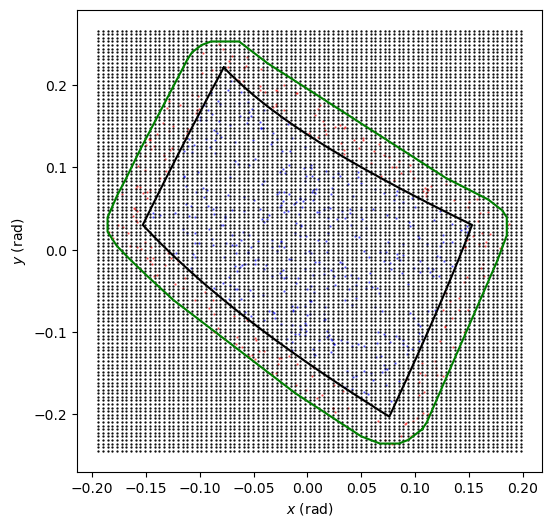

In [38]:
fig = plt.figure(1,figsize=(6,6))
ax = fig.add_subplot(111)

r_outer = projected_map['outer_region_points']
x_outer = r_outer[:,0] ; y_outer = r_outer[:,1]

r_pix = projected_map['search_region_points']
r_edge = projected_map['search_region_edge']

x_pix = r_pix[:,0] ; y_pix = r_pix[:,1]
x_edge = r_edge[:,0] ; y_edge = r_edge[:,1]

ax.scatter(x_outer,y_outer, c = 'r', alpha = 0.5, s = 0.5)
ax.scatter(x_pix,y_pix, c = 'b', alpha = 0.5, s = 0.5)
ax.plot(x_edge,y_edge, c = 'k')
ax.scatter(arr_b[:,0], arr_b[:,1], s = 0.4, c = 'k')
ax.plot(x_out_edge,y_out_edge, c = 'green')
ax.set_xlabel('$x$ (rad)')
ax.set_ylabel('$y$ (rad)')